In [1]:
using LinearAlgebra
using WAV
using Plots
pyplot();

using Pkg
Pkg.activate("../")

using Revise
using SpeechFeatures
using ExpFamilyDistributions
using BayesianModels

 Activating environment at `~/GithubRepositories/BayesianModels/Project.toml`
┌ Info: Precompiling BayesianModels [56ff943f-52c4-4398-bcf1-974dffc1fcd6]
└ @ Base loading.jl:1260


Download an example audio file from the TIMIT 
corpus.

In [2]:
using Base.Filesystem: isfile
if ! isfile("LDC93S1.wav")
    run(`wget https://catalog.ldc.upenn.edu/desc/addenda/LDC93S1.wav`)
end

Load the audio file

sampling freq: 16000.0 Hz
duration: 2.92 s


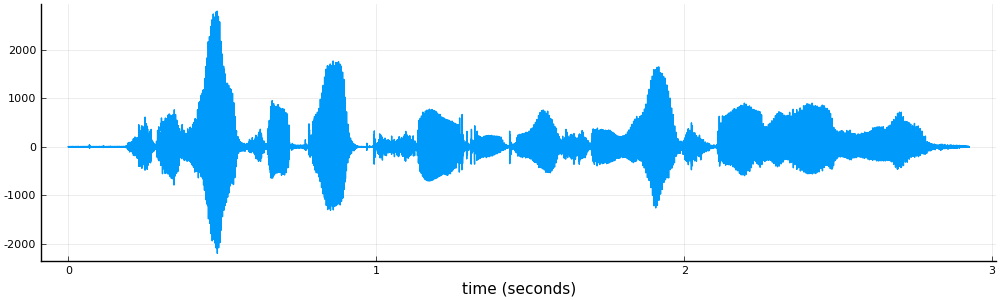

In [3]:
channels, srate = wavread("LDC93S1.wav", format="double")
channels *= typemax(Int16)
s = channels[:, 1]

println("sampling freq: $srate Hz\nduration: $(round(length(s) / srate, digits=2)) s")

t = range(0, length(s) / srate, length=length(s))
plot(t, s, size=(1000, 300), xlabel="time (seconds)", legend = false)

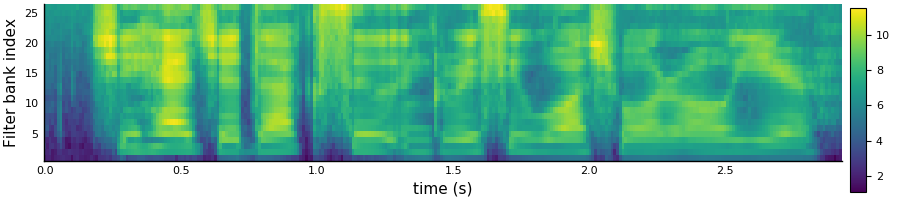

In [4]:
logfbank = LogMelSpectrum(
    fftlen = fftlen_auto,
    srate = 16000,
    frameduration = 0.025,
    framestep = 0.01,
    removedc = true,
    preemphasis = 0.97,
    dithering = 0.,
    windowfn = hann,
    windowpower = 1.0,
    nfilters = 26,
    lofreq = 80,
    hifreq = 8000
)
X = s |> logfbank

heatmap(
    Vector(range(0, length(s) / srate, length=size(X, 2))),
    1:size(X, 1),
    X,
    size = (900, 200),
    xlabel = "time (s)",
    ylabel = "Filter bank index",
    c = :viridis
)

In [5]:
K = 10
model = ARNormal(dim = size(X, 1), order = K);

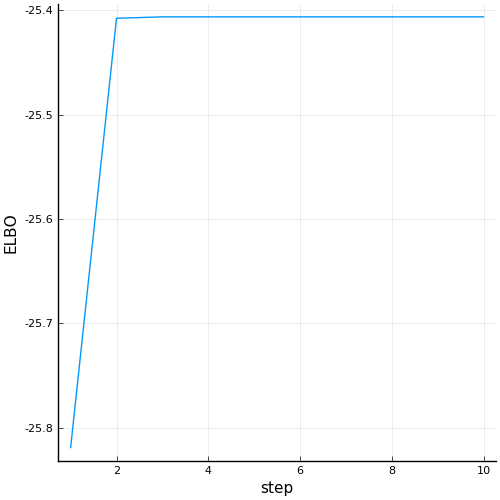

In [6]:
nsteps = 10
elbos = []

validrate = 3
for i = 1:nsteps
    for param in getconjugateparams(model)
        stats = X |> param.stats
        accstats = dropdims(sum(stats, dims = 2), dims=2)
        update!(param.posterior, naturalparam(param.prior) + accstats)
    end

    # This is just for monitoring, not actually needed for training.
    push!(elbos, elbo(model, X) / size(X, 2))   
end

ptraining = plot(
    1:nsteps, elbos,
    size=(500, 500),
    xlabel="step",
    ylabel="ELBO",
    legend=false
)

In [7]:
function sample(μ, Σ, N::Int)
    C = cholesky(Σ)
    μ .+ C.L * randn(length(μ), N)
end

plots = []
for d = 1:26
    fea_srate = 100
    gain = sqrt(1 / mean(model.filters[d].λ.posterior)[1])
    filters = sample(model.filters[d].h.posterior.μ[1:K], 
                     model.filters[d].h.posterior.Σ[1:K, 1:K], 100)
    filters = reverse(filters, dims=1)
    mfilter = meanfilter(model.filters[d])

    p = plot(legend = false, ylims = (-1.5, 1.5))
    plot!(p, filters, alpha = 0.5, width = 0.1, color = "blue")
    plot!(p, mfilter, color = "red")
    push!(plots, p)
end

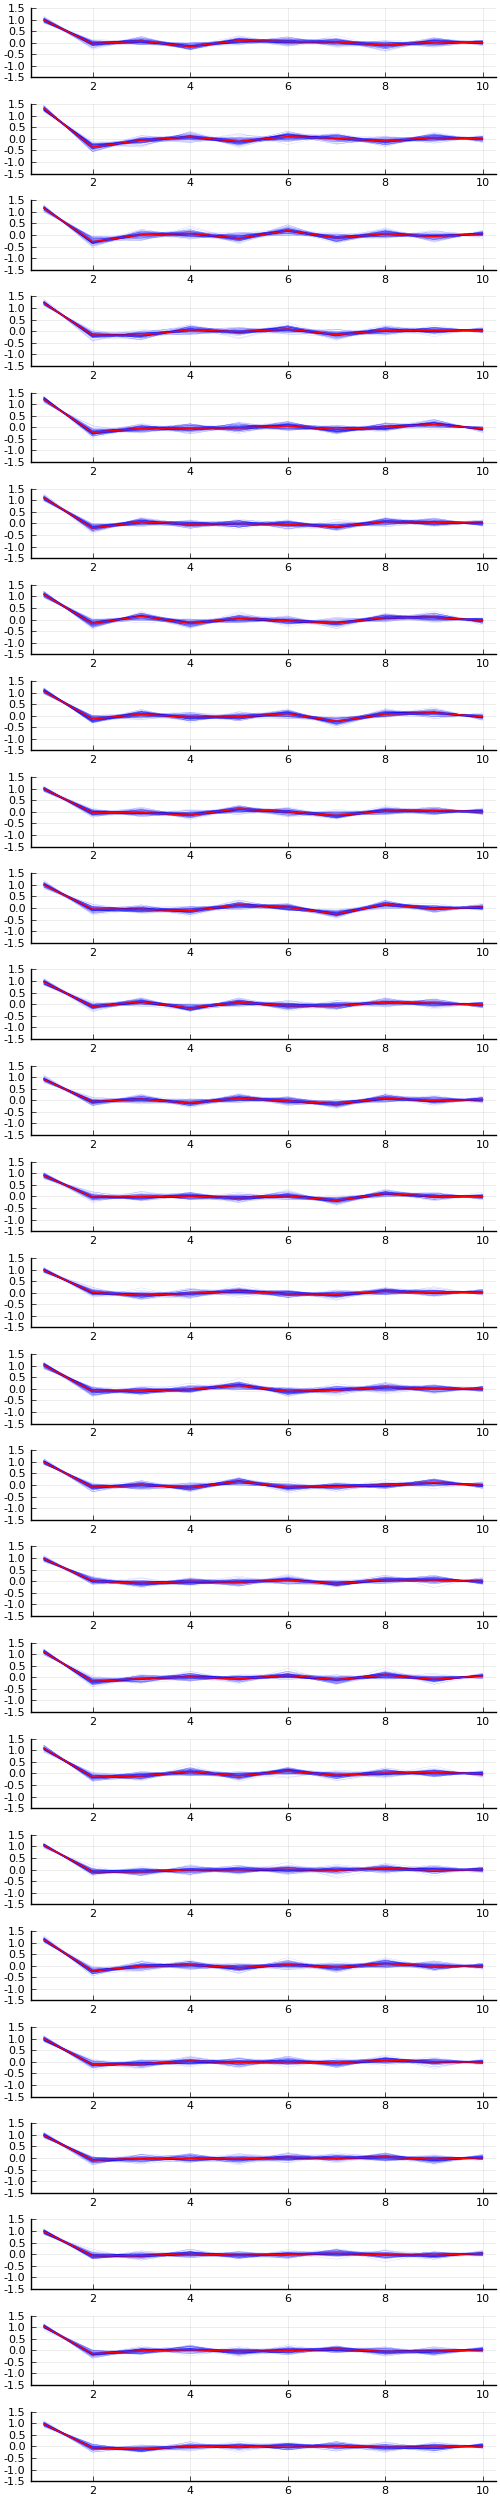

In [8]:
# Sample from the posterior of the AR coefficients per dimension.
plot(plots..., layout = (26, 1), legend = false, size = (500, 2500))